In [67]:
%pip install geopandas numpy pandas seaborn statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [68]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [69]:
gdf_tracts = gpd.read_file("https://github.com/dylanqcdi/PPD534FA23/raw/main/tl_2022_06_tract/tl_2022_06_tract.shp")
gdf_tracts.shape

(9129, 13)

In [70]:
gdf_boundary = gpd.read_file("https://github.com/dylanqcdi/PPD534FA23/raw/main/City_Boundary/City_Boundary.shp")
gdf_boundary.shape

(1, 3)

In [71]:
gdf_tracts.crs == gdf_boundary.crs

False

In [72]:
gdf_boundary = gdf_boundary.to_crs(gdf_tracts.crs)

In [73]:
gdf_lacity = gpd.clip(gdf_tracts, gdf_boundary)
gdf_lacity.shape

(1274, 13)

In [74]:
gdf_income1 = gpd.read_file("https://raw.githubusercontent.com/gboeing/ppd534/main/data/census_tracts_data_la.csv")
gdf_income = gdf_income1.rename(columns={"GEOID10": "GEOID"})
gdf_income.shape

(2346, 26)

In [75]:
lacensus = pd.merge(gdf_lacity, gdf_income, how="left", left_on="GEOID", right_on="GEOID")
gdf_lacensus = gpd.GeoDataFrame(lacensus, geometry='geometry_x')
gdf_lacensus.set_geometry('geometry_x', inplace=True)
gdf_lacensus.crs = "EPSG:4326"
gdf_lacensus.shape

(1274, 38)

In [76]:
df_collision = pd.read_csv("https://raw.githubusercontent.com/dylanqcdi/PPD534FA23/a8c54e8cb797d9266490e6473112b898b95c8d7e/Collision_Points_SCAG.csv")
df_collision["geometry"] = gpd.points_from_xy(x=df_collision["X"], y=df_collision["Y"])
gdf_collision = gpd.GeoDataFrame(df_collision, crs="epsg:4326")
gdf_collision.shape

(20213, 34)

In [77]:
df_collision = pd.read_csv("https://raw.githubusercontent.com/dylanqcdi/PPD534FA23/a8c54e8cb797d9266490e6473112b898b95c8d7e/Collision_Points_SCAG.csv")
df_collision["geometry"] = gpd.points_from_xy(x=df_collision["X"], y=df_collision["Y"])
gdf_collision = gpd.GeoDataFrame(df_collision, crs="epsg:4326")
county = ["LOS ANGELES"]
gdf_collision = gdf_collision[gdf_collision["COUNTY"].isin(county)]
gdf_lacollision = gpd.clip(gdf_collision, gdf_lacensus)
gdf_lacollision.shape

(6165, 34)

In [78]:
gdf = gpd.sjoin(gdf_lacensus, gdf_lacollision, how="left", predicate='contains')
gdf.shape

(6396, 72)

In [79]:
gdf['med_household_income'] = gdf['med_household_income'].replace('\$', '', regex=True)
gdf['med_household_income'] = gdf['med_household_income'].replace('', np.nan)
gdf['med_household_income'] = gdf['med_household_income'].astype(float)

In [80]:
attribute = ['COLLISION_SEVERITY', 'NUMBER_KILLED',
       'NUMBER_INJURED', 'COUNT_SEVERE_INJ', 'COUNT_VISIBLE_INJ',
       'COUNT_COMPLAINT_PAIN', 'COUNT_PED_KILLED', 'COUNT_PED_INJURED',
       'COUNT_BICYCLIST_KILLED', 'COUNT_BICYCLIST_INJURED', 'COUNT_MC_KILLED',
       'COUNT_MC_INJURED']
sum_collision = gdf.groupby("GEOID")[attribute].sum()
sum_collision.shape

(1274, 12)

In [81]:
gdf = gdf.merge(sum_collision, left_on="GEOID",right_index=True, how="left")
gdf.shape

(6396, 84)

In [82]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry_x',
       'total_pop', 'median_age', 'pct_hispanic', 'pct_white', 'pct_black',
       'pct_asian', 'pct_male', 'pct_single_family_home', 'med_home_value',
       'med_rooms_per_home', 'pct_built_before_1940', 'pct_renting',
       'rental_vacancy_rate', 'avg_renter_household_size', 'med_gross_rent',
       'med_household_income', 'mean_commute_time', 'pct_commute_drive_alone',
       'pct_below_poverty', 'pct_college_grad_student',
       'pct_same_residence_year_ago', 'pct_bachelors_degree',
       'pct_english_only', 'pct_foreign_born', 'geometry_y', 'index_right',
       'X', 'Y', 'OBJECTID', 'CASE_ID', 'ACCIDENT_YEAR', 'COLLISION_DATE',
       'COLLISION_TIME', 'DAY_OF_WEEK', 'PRIMARY_RD', 'SECONDARY_RD',
       'DIRECTION', 'INTERSECTION', 'STATE_HWY_IND', 'STATE_ROUTE',
       'RAMP_INTERSECTION', 'COLLISION_SEVERITY_x', 'NUMBER_K

**Deadly Collision by Census Tract**

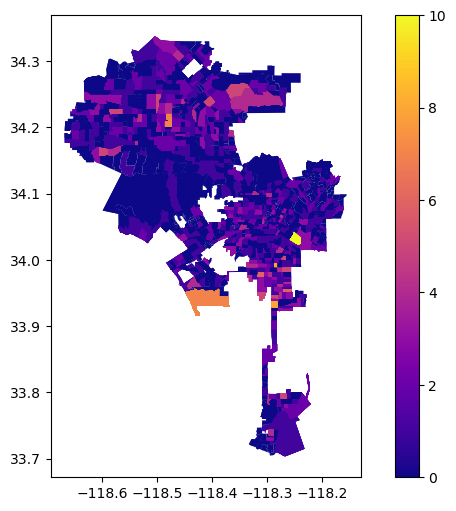

In [83]:
ax = gdf.plot(column="NUMBER_KILLED_y",
                        cmap="plasma",
                        lw=0.2,
                        figsize=(9, 6),
                        legend=True)

In [89]:
gdf["NUMBER_KILLED_y"] = gdf["NUMBER_KILLED_y"].astype(int)
gdf["COUNT_SEVERE_INJ_y"] = gdf["COUNT_SEVERE_INJ_y"].astype(int)
gdf["total_pop"] = gdf["total_pop"].astype(float)
gdf["KSI_DENSITY"] = (gdf["NUMBER_KILLED_y"] + gdf["COUNT_SEVERE_INJ_y"]) / gdf["total_pop"] * 100
gdf["COUNT_SEVERE_INJ_y"].head(50)

0      0
1      0
2      1
3      0
4      4
4      4
4      4
4      4
5      0
6      5
6      5
6      5
6      5
6      5
6      5
7      1
8      2
8      2
9      2
9      2
10     4
10     4
10     4
10     4
11     2
11     2
12     1
13     0
14     0
15     0
16     1
16     1
17     0
18     1
19     0
20     0
21     2
21     2
22     1
23    12
23    12
23    12
23    12
23    12
23    12
23    12
23    12
23    12
23    12
23    12
Name: COUNT_SEVERE_INJ_y, dtype: int32